In [9]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

from einops import rearrange

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from bliss.surveys.des import DarkEnergySurvey, DESDownloader

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict
import case_studies.galaxy_clustering.utils.diagnostics as diagnostics
from astropy.io import fits
from astropy.visualization import make_lupton_rgb

import subprocess

In [2]:
DES_SVA_TILES = pd.read_pickle("/data/scratch/des/sva_map.pickle")
CACHED_DATA_PATH = (
    "/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles"
)
DES_BANDS = ("g", "r", "i", "z")
GROUNDTRUTH_PATH = "/data/scratch/des/redmapper_groundtruth"
DES_SUBDIR = np.random.choice(DES_SVA_TILES)
DES_SUBDIR

'DES0221-0416'

In [3]:
DES_DIR = Path(
    "/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/"
)

In [4]:
main_path = DES_DIR / Path(DES_SUBDIR) / Path(f"{DES_SUBDIR}_dr2_main.fits")
flux_path = DES_DIR / Path(DES_SUBDIR) / Path(f"{DES_SUBDIR}_dr2_flux.fits")
main_data = fits.getdata(main_path)
main_df = pd.DataFrame(main_data)
flux_data = fits.getdata(flux_path)
flux_df = pd.DataFrame(flux_data)
full_df = pd.merge(
    main_df, flux_df, left_on="COADD_OBJECT_ID", right_on="COADD_OBJECT_ID", how="left"
)
full_df

,COADD_OBJECT_ID,TILENAME_x,HPIX_32_x,HPIX_64_x,HPIX_1024_x,HPIX_4096_x,HPIX_16384_x,RA_x,DEC_x,ALPHAWIN_J2000_x,...,WAVG_FLUX_PSF_G_y,WAVG_FLUX_PSF_R_y,WAVG_FLUX_PSF_I_y,WAVG_FLUX_PSF_Z_y,WAVG_FLUX_PSF_Y_y,WAVG_FLUXERR_PSF_G_y,WAVG_FLUXERR_PSF_R_y,WAVG_FLUXERR_PSF_I_y,WAVG_FLUXERR_PSF_Z_y,WAVG_FLUXERR_PSF_Y_y
0,1267899566,DES0221-0416,4422,17691,4529051,72464823,1159437176,34.908707,-4.135119,34.908707,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf
1,1267879141,DES0221-0416,4422,17691,4529128,72466054,1159456868,34.908711,-3.923382,34.908711,...,inf,inf,423.088501,inf,inf,-inf,-inf,128.330505,-inf,-inf
2,1267879823,DES0221-0416,4422,17691,4529128,72466052,1159456840,34.908720,-3.930403,34.908720,...,inf,372.785736,1210.309570,2120.062988,2707.157227,-inf,22.805719,36.642735,71.494102,309.507568
3,1267883938,DES0221-0416,4422,17691,4529079,72465277,1159444439,34.909984,-3.974551,34.909984,...,205.526077,249.099197,311.973511,inf,inf,27.424919,28.750467,80.061142,-inf,-inf
4,1267942400,DES0221-0416,4422,17691,4528930,72462890,1159406241,34.908728,-4.560357,34.908728,...,1160.355835,1482.140503,1502.570435,1675.274780,2684.472656,18.200705,24.058210,36.569542,72.502449,387.027069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69604,1267939932,DES0221-0416,4422,17689,4528610,72457774,1159324395,35.624527,-4.535412,35.624527,...,inf,321.490265,672.390320,1162.962158,inf,-inf,29.485203,40.787178,80.385887,-inf
69605,1267929383,DES0221-0416,4422,17689,4528619,72457911,1159326581,35.624528,-4.432963,35.624528,...,219.047714,224.357559,496.670685,inf,1653.158203,21.509441,45.874218,68.916466,-inf,298.207367
69606,1267886522,DES0221-0416,4422,17691,4529015,72464244,1159427909,35.624528,-4.003674,35.624528,...,685.474976,1174.898682,1551.246216,1747.705933,1672.951416,18.135859,20.936184,33.088215,60.868103,240.709183
69607,1267880975,DES0221-0416,4423,17694,4529698,72475182,1159602914,35.624534,-3.943025,35.624534,...,inf,inf,inf,inf,inf,-inf,-inf,-inf,-inf,-inf


In [5]:
fluxes = np.array(
            full_df[
                [
                    "FLUX_AUTO_G_x",
                    "FLUX_AUTO_R_x",
                    "FLUX_AUTO_I_x",
                    "FLUX_AUTO_Z_x",
                    "FLUX_AUTO_Y_x",
                ]
            ]
        )

fluxes *= (fluxes > 0)

hlrs = 0.263 * np.array(full_df["FLUX_RADIUS_R"])
hlrs = 1e-4 + hlrs * (hlrs > 0)
a = np.array(full_df["A_IMAGE"])
b = np.array(full_df["B_IMAGE"])
g = (a - b) / (a + b)
angle = np.arctan(b / a)
g1 = g * np.cos(angle)
g2 = g * np.sin(angle)

In [6]:
mock_catalog = pd.DataFrame()
mock_catalog["RA"] = np.array(full_df["ALPHAWIN_J2000_x"])
mock_catalog["DEC"] = np.array(full_df["DEC_x"])
mock_catalog["X"] = np.array(full_df["XWIN_IMAGE_R"])
mock_catalog["Y"] = np.array(full_df["YWIN_IMAGE_R"])
mock_catalog["MEM"] = 0
mock_catalog["FLUX_G"] = fluxes[:, 0]
mock_catalog["FLUX_R"] = fluxes[:, 1]
mock_catalog["FLUX_I"] = fluxes[:, 2]
mock_catalog["FLUX_Z"] = fluxes[:, 3]
mock_catalog["HLR"] = hlrs
mock_catalog["FRACDEV"] = 0
mock_catalog["G1"] = g1
mock_catalog["G2"] = g2
mock_catalog["Z"] = 0
mock_catalog["SOURCE_TYPE"] = 0

In [7]:
mock_catalog

,RA,DEC,X,Y,MEM,FLUX_G,FLUX_R,FLUX_I,FLUX_Z,HLR,FRACDEV,G1,G2,Z,SOURCE_TYPE
0,34.908707,-4.135119,9887.584519,6801.287413,0,56.771339,76.088043,60.688725,199.815430,0.513034,0,0.096914,0.075689,0,0
1,34.908711,-3.923382,9889.350442,9698.222944,0,19.170216,77.168556,32.815876,106.557602,0.512114,0,0.000087,0.000087,0,0
2,34.908720,-3.930403,9888.467182,9602.064858,0,92.141861,451.644836,1504.629028,2708.659180,0.707503,0,0.059115,0.050580,0,0
3,34.909984,-3.974551,9870.728712,8997.833159,0,233.360947,285.993774,519.480286,516.301331,0.677869,0,0.053051,0.046084,0,0
4,34.908728,-4.560357,9884.328649,979.094863,0,1096.018677,1442.668945,1460.678833,1727.294067,0.575421,0,0.019179,0.018191,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69604,35.624527,-4.535412,116.582809,1320.352956,0,97.513741,327.760864,844.826233,1229.673584,0.745125,0,0.012661,0.012223,0,0
69605,35.624528,-4.432963,116.221989,2722.822467,0,178.108124,189.679932,282.003296,314.299622,0.633761,0,0.060474,0.051569,0,0
69606,35.624528,-4.003674,113.430663,8599.246909,0,1509.080200,2872.531494,3552.551758,4133.452637,1.303882,0,0.022626,0.021263,0,0
69607,35.624534,-3.943025,113.621160,9429.284204,0,46.200783,60.928932,99.448677,279.562317,0.562684,0,0.022481,0.021135,0,0


In [8]:
from astropy.io import ascii as astro_ascii
from astropy.table import Table

DATA_PATH = "/home/kapnadak/bliss/case_studies/galaxy_clustering/data"
CATALOG_PATH = os.path.join(DATA_PATH, "catalogs")
if not os.path.exists(CATALOG_PATH):
    os.makedirs(CATALOG_PATH)

file_name = f"{CATALOG_PATH}/galsim_des_000.dat"
catalog_table = Table.from_pandas(mock_catalog)
astro_ascii.write(catalog_table, file_name, format="no_header", overwrite=True)

In [10]:
image_size = 10000
nfiles = 1
data_dir = DATA_PATH
input_dir = f"{DATA_PATH}/catalogs"
output_dir = f"{DATA_PATH}/images"
output_ext = "galsim_des_000_g.fits"
psf_dir = f"/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/{DES_SUBDIR}"
psf_file = [f for f in os.listdir(psf_dir) if f.endswith("g_nobkg.psf")][0]
args = []
GALSIM_PATH = "/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml"
args.append("galsim")
args.append(f"{GALSIM_PATH}")
args.append(f"variables.image_size={image_size}")
args.append(f"variables.nfiles={nfiles}")
args.append(f"variables.input_dir={input_dir}")
args.append(f"variables.input_file=galsim_des_000.dat")
args.append(f"variables.output_dir={output_dir}")
args.append(f"variables.output_file={output_ext}")
args.append(f"variables.psf_dir={psf_dir}")
args.append(f"variables.psf_file={psf_file}")
args.append(f"variables.flux_col=5")
subprocess.run(args, shell=False, check=False)

Reading config file /home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml
These fields are not (directly) processed by the config processing.
Start file 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_g.fits
Using 32 processes for stamp processing
File 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_g.fits: time = 303.463802 sec
Done building files


CompletedProcess(args=['galsim', '/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml', 'variables.image_size=10000', 'variables.nfiles=1', 'variables.input_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/catalogs', 'variables.input_file=galsim_des_000.dat', 'variables.output_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images', 'variables.output_file=galsim_des_000_g.fits', 'variables.psf_dir=/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0221-0416', 'variables.psf_file=DES0221-0416_r4920p01_g_nobkg.psf', 'variables.flux_col=5'], returncode=0)

In [11]:
image_size = 10000
nfiles = 1
data_dir = DATA_PATH
input_dir = f"{DATA_PATH}/catalogs"
output_dir = f"{DATA_PATH}/images"
output_ext = "galsim_des_000_r.fits"
psf_dir = f"/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/{DES_SUBDIR}"
psf_file = [f for f in os.listdir(psf_dir) if f.endswith("r_nobkg.psf")][0]
args = []
GALSIM_PATH = "/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml"
args.append("galsim")
args.append(f"{GALSIM_PATH}")
args.append(f"variables.image_size={image_size}")
args.append(f"variables.nfiles={nfiles}")
args.append(f"variables.input_dir={input_dir}")
args.append(f"variables.input_file=galsim_des_000.dat")
args.append(f"variables.output_dir={output_dir}")
args.append(f"variables.output_file={output_ext}")
args.append(f"variables.psf_dir={psf_dir}")
args.append(f"variables.psf_file={psf_file}")
args.append(f"variables.flux_col=6")
subprocess.run(args, shell=False, check=False)

Reading config file /home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml
These fields are not (directly) processed by the config processing.
Start file 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_r.fits
Using 32 processes for stamp processing
File 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_r.fits: time = 302.522518 sec
Done building files


CompletedProcess(args=['galsim', '/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml', 'variables.image_size=10000', 'variables.nfiles=1', 'variables.input_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/catalogs', 'variables.input_file=galsim_des_000.dat', 'variables.output_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images', 'variables.output_file=galsim_des_000_r.fits', 'variables.psf_dir=/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0221-0416', 'variables.psf_file=DES0221-0416_r4920p01_r_nobkg.psf', 'variables.flux_col=6'], returncode=0)

In [12]:
image_size = 10000
nfiles = 1
data_dir = DATA_PATH
input_dir = f"{DATA_PATH}/catalogs"
output_dir = f"{DATA_PATH}/images"
output_ext = "galsim_des_000_i.fits"
psf_dir = f"/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/{DES_SUBDIR}"
psf_file = [f for f in os.listdir(psf_dir) if f.endswith("i_nobkg.psf")][0]
args = []
GALSIM_PATH = "/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml"
args.append("galsim")
args.append(f"{GALSIM_PATH}")
args.append(f"variables.image_size={image_size}")
args.append(f"variables.nfiles={nfiles}")
args.append(f"variables.input_dir={input_dir}")
args.append(f"variables.input_file=galsim_des_000.dat")
args.append(f"variables.output_dir={output_dir}")
args.append(f"variables.output_file={output_ext}")
args.append(f"variables.psf_dir={psf_dir}")
args.append(f"variables.psf_file={psf_file}")
args.append(f"variables.flux_col=7")
subprocess.run(args, shell=False, check=False)

Reading config file /home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml
These fields are not (directly) processed by the config processing.
Start file 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_i.fits
Using 32 processes for stamp processing
File 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_i.fits: time = 273.708541 sec
Done building files


CompletedProcess(args=['galsim', '/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml', 'variables.image_size=10000', 'variables.nfiles=1', 'variables.input_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/catalogs', 'variables.input_file=galsim_des_000.dat', 'variables.output_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images', 'variables.output_file=galsim_des_000_i.fits', 'variables.psf_dir=/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0221-0416', 'variables.psf_file=DES0221-0416_r4920p01_i_nobkg.psf', 'variables.flux_col=7'], returncode=0)

In [13]:
image_size = 10000
nfiles = 1
data_dir = DATA_PATH
input_dir = f"{DATA_PATH}/catalogs"
output_dir = f"{DATA_PATH}/images"
output_ext = "galsim_des_000_z.fits"
psf_dir = f"/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/{DES_SUBDIR}"
psf_file = [f for f in os.listdir(psf_dir) if f.endswith("z_nobkg.psf")][0]
args = []
GALSIM_PATH = "/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml"
args.append("galsim")
args.append(f"{GALSIM_PATH}")
args.append(f"variables.image_size={image_size}")
args.append(f"variables.nfiles={nfiles}")
args.append(f"variables.input_dir={input_dir}")
args.append(f"variables.input_file=galsim_des_000.dat")
args.append(f"variables.output_dir={output_dir}")
args.append(f"variables.output_file={output_ext}")
args.append(f"variables.psf_dir={psf_dir}")
args.append(f"variables.psf_file={psf_file}")
args.append(f"variables.flux_col=8")
subprocess.run(args, shell=False, check=False)

Reading config file /home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml
These fields are not (directly) processed by the config processing.
Start file 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_z.fits
Using 32 processes for stamp processing
File 0 = /home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_z.fits: time = 254.191040 sec
Done building files


CompletedProcess(args=['galsim', '/home/kapnadak/bliss/case_studies/galaxy_clustering/data_generation/custom-single-image-galsim.yaml', 'variables.image_size=10000', 'variables.nfiles=1', 'variables.input_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/catalogs', 'variables.input_file=galsim_des_000.dat', 'variables.output_dir=/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images', 'variables.output_file=galsim_des_000_z.fits', 'variables.psf_dir=/nfs/turbo/lsa-regier/scratch/gapatron/psf-models/dr2_tiles/DES0221-0416', 'variables.psf_file=DES0221-0416_r4920p01_z_nobkg.psf', 'variables.flux_col=8'], returncode=0)

In [14]:
environ["CUDA_VISIBLE_DEVICES"] = "1"

In [15]:
with initialize(config_path="../conf/", version_base=None):
    cfg = compose("config")

In [16]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)

<All keys matched successfully>

In [17]:
image_galsim_r = torch.tensor(fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_r.fits").astype(np.float32)).unsqueeze(0)
image_galsim_g = torch.tensor(fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_g.fits").astype(np.float32)).unsqueeze(0)
image_galsim_i = torch.tensor(fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_i.fits").astype(np.float32)).unsqueeze(0)
image_galsim_z = torch.tensor(fits.getdata("/home/kapnadak/bliss/case_studies/galaxy_clustering/data/images/galsim_des_000_z.fits").astype(np.float32)).unsqueeze(0)
image_bands = [image_galsim_g, image_galsim_r, image_galsim_i, image_galsim_z]
full_image = torch.cat(image_bands, axis=0)
full_image.shape

torch.Size([4, 10000, 10000])

In [18]:
item = full_image.unfold(dimension=1, size=2560, step=2480).unfold(dimension=2, size=2560, step=2480)
item.shape

torch.Size([4, 4, 4, 2560, 2560])

In [19]:
outputs = torch.zeros((4,4,10,10))

for i in range(4):
    for j in range(4):
        image = item[:,i,j,:,:].unsqueeze(0)
        batch = {"images": image, "background": torch.zeros_like(image)}
        batch_size, _n_bands, h, w = batch["images"].shape[0:4]
        ht, wt = h // encoder.tile_slen, w // encoder.tile_slen

        input_lst = [inorm.get_input_tensor(batch) for inorm in encoder.image_normalizers]
        x = torch.cat(input_lst, dim=2)
        x_features = encoder.net(x)
        mask = torch.zeros([batch_size, ht, wt])
        context = encoder.make_context(None, mask)
        x_cat_marginal = encoder.catalog_net(x_features, context)
        outputs[i,j,:,:] = encoder.var_dist.sample(x_cat_marginal, use_mode=True)["membership"].squeeze()
outputs = outputs.bool()


In [20]:
gt_filename = f"/{GROUNDTRUTH_PATH}/{DES_SUBDIR}_redmapper_groundtruth.npy"
gt_memberships = torch.from_numpy(np.load(gt_filename))
unfolded_gt = gt_memberships.unfold(dimension=0, size=2560, step=2480).unfold(
    dimension=1, size=2560, step=2480
)
pred_memberships = torch.repeat_interleave(outputs, repeats=encoder.tile_slen, dim=2)
pred_memberships = torch.repeat_interleave(pred_memberships, repeats=encoder.tile_slen, dim=3)
tp = (pred_memberships * unfolded_gt).sum()
tn = (~pred_memberships * ~unfolded_gt).sum()
fp = (pred_memberships * ~unfolded_gt).sum()
fn = (~pred_memberships * unfolded_gt).sum()
acc = (tp + tn) / (tp + tn + fp + fn)
prec = tp / (tp + fp + 1e-6)
rec = tp / (tp + fn + 1e-6)
f1 = 2 * prec * rec / (prec + rec + 1e-6)
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1: {f1}")

Accuracy: 0.9480322003364563
Precision: 0.0
Recall: 0.0
F1: 0.0


In [21]:
def blend_images(original, overlay, alpha=0.5, img_crop=0):
    # Ensure the original image is in float
    if original.max() > 1.0:
        original = original / 255.0
    # Blend the images
    blended = original * (1 - alpha) + overlay * alpha
    blended = blended[img_crop: blended.shape[0] - img_crop, img_crop: blended.shape[1] - img_crop]
    print(blended.shape)
    return blended

(10000, 10000, 3)


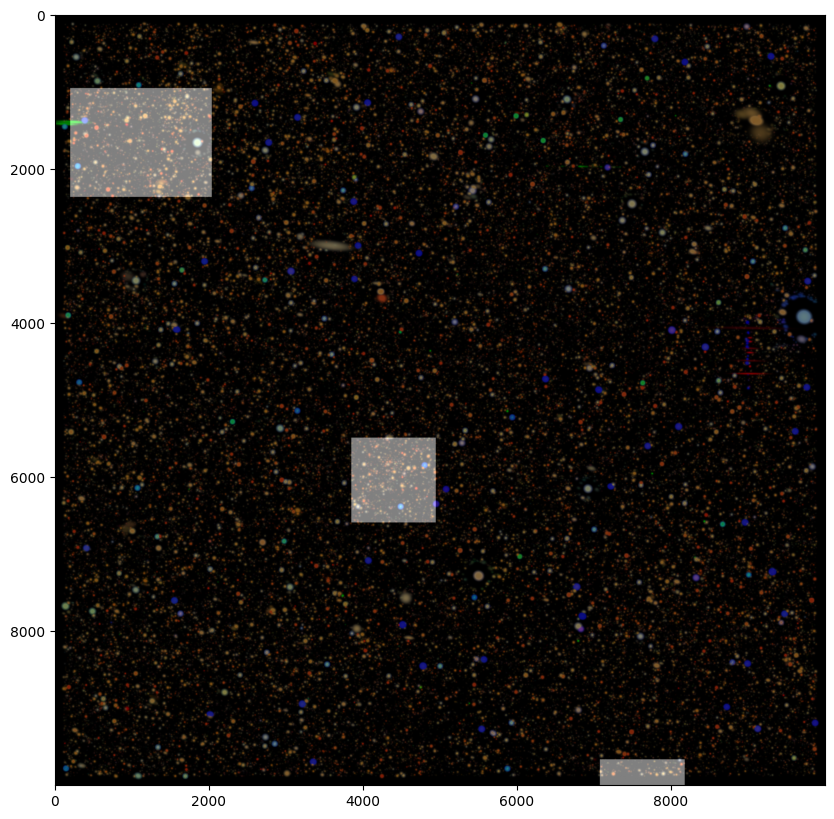

In [22]:
rgb_default = make_lupton_rgb(full_image[2,:,:], full_image[1,:,:], full_image[0,:,:])
overlay = gt_memberships.unsqueeze(2).repeat(1,1,3).numpy()
blended = blend_images(rgb_default, overlay)
plt.figure(figsize=(10,10))
plt.imshow(blended)

In [23]:
rearranged_memberships = rearrange(pred_memberships, 'd0 d1 d2 d3 -> (d0 d2) (d1 d3)')
row_include = torch.from_numpy(np.concatenate([np.arange(0,2560), np.arange(2640,5120), np.arange(5200,7680), np.arange(7760,10240)]))
folded_outputs = torch.index_select(rearranged_memberships, 0, row_include)
folded_outputs = torch.index_select(folded_outputs, 1, row_include)

(10000, 10000, 3)


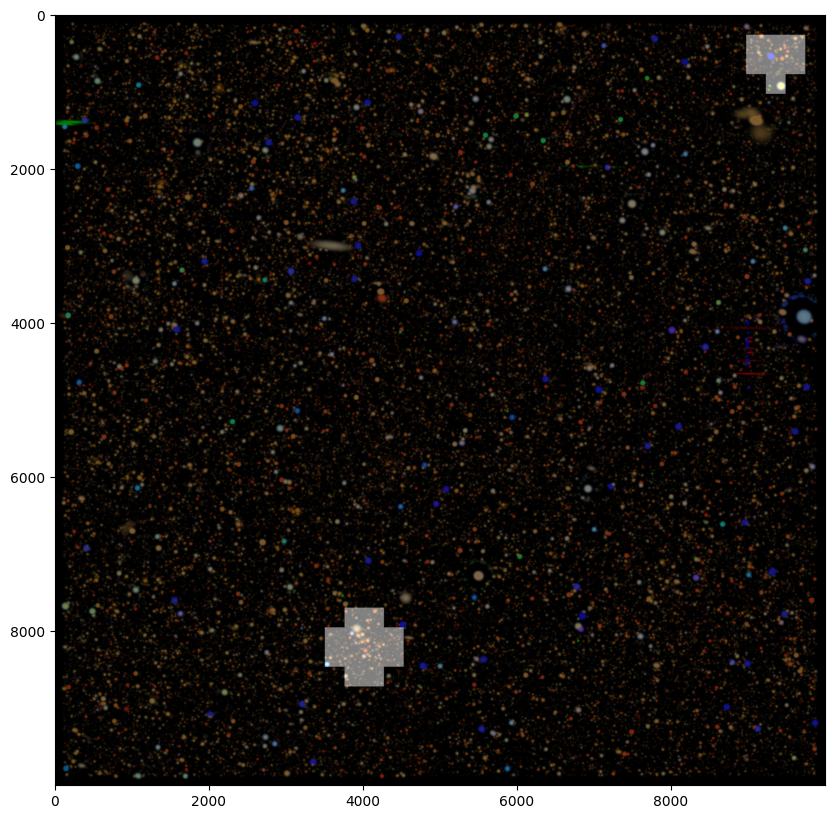

In [24]:
rgb_default = make_lupton_rgb(full_image[2,:,:], full_image[1,:,:], full_image[0,:,:])
overlay = folded_outputs.unsqueeze(2).repeat(1,1,3).numpy()
blended = blend_images(rgb_default, overlay)
plt.figure(figsize=(10,10))
plt.imshow(blended)